In [1]:
# this mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# enter the foldername in your Drive where you have saved the unzipped
# assignment folder, e.g. 'cs231n/assignments/assignment3/'
FOLDERNAME = 'cs231n/assignments/assignment2/'
assert FOLDERNAME is not None, "[!] Enter the foldername."

# now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

# this downloads the CIFAR-10 dataset to your Drive
# if it doesn't already exist.
%cd drive/My\ Drive/$FOLDERNAME/cs231n/datasets/
!bash get_datasets.sh
%cd /content

Mounted at /content/drive
/content/drive/My Drive/cs231n/assignments/assignment2/cs231n/datasets
/content


Import Files

In [2]:
import torch
#assert '.'.join(torch.__version__.split('.')[:2]) == '1.4'
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler

import torchvision.datasets as dset
import torchvision.transforms as T
import torch.nn.functional as F 

import numpy as np
from matplotlib import pyplot as plt

Upload Data

In [3]:
NUM_TRAIN = 49000

# The torchvision.transforms package provides tools for preprocessing data
# and for performing data augmentation; here we set up a transform to
# preprocess the data by subtracting the mean RGB value and dividing by the
# standard deviation of each RGB value; we've hardcoded the mean and std.
transform = T.Compose([
                T.ToTensor(),
                T.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
            ])

# We set up a Dataset object for each split (train / val / test); Datasets load
# training examples one at a time, so we wrap each Dataset in a DataLoader which
# iterates through the Dataset and forms minibatches. We divide the CIFAR-10
# training set into train and val sets by passing a Sampler object to the
# DataLoader telling how it should sample from the underlying Dataset.
cifar10_train = dset.CIFAR10('./cs231n/datasets', train=True, download=True,
                             transform=transform)
loader_train = DataLoader(cifar10_train, batch_size=64, 
                          sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))

cifar10_val = dset.CIFAR10('./cs231n/datasets', train=True, download=True,
                           transform=transform)
loader_val = DataLoader(cifar10_val, batch_size=64, 
                        sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN, 50000)))

cifar10_test = dset.CIFAR10('./cs231n/datasets', train=False, download=True, 
                            transform=transform)
loader_test = DataLoader(cifar10_test, batch_size=64)

Extracting ./cs231n/datasets/cifar-10-python.tar.gz to ./cs231n/datasets
Files already downloaded and verified
Files already downloaded and verified


Use GPU

In [4]:
USE_GPU = True

dtype = torch.float32 # we will be using float throughout this tutorial

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# Constant to control how frequently we print train loss
print_every = 100

print('using device:', device)

using device: cuda


Flatten Shape

In [5]:
def flatten(x):
    N = x.shape[0] # read in N, C, H, W
    return x.view(N, -1)  # "flatten" the C * H * W values into a single vector per image

# We need to wrap `flatten` function in a module in order to stack it
# in nn.Sequential

class Flatten(nn.Module):
    def forward(self, x):
        return flatten(x)

Check Accuracy

In [22]:
def check_accuracy_part34(loader, model):
    #if loader.dataset.train:
    #    print('Checking accuracy on validation set')
    #else:
    #    print('Checking accuracy on test set')
    num_correct = 0
    num_samples = 0
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)
            scores = model(x)
            _, preds = scores.max(1)
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)
        acc = float(num_correct) / num_samples
        #print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))
    return acc

Train Model

In [7]:
def train_part34(model, optimizer, epochs=1):
    """
    Train a model on CIFAR-10 using the PyTorch Module API.

    Inputs:
    - model: A PyTorch Module giving the model to train.
    - optimizer: An Optimizer object we will use to train the model
    - epochs: (Optional) A Python integer giving the number of epochs to train for

    Returns: Nothing, but prints model accuracies during training.
    """
    model = model.to(device=device)  # move the model parameters to CPU/GPU
    valid_acc_list = []
    for e in range(epochs):
        model.train()
        val_acc_it = 0
        for t, (x, y) in enumerate(loader_train):
            model.train()  # put model to training mode
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)
            scores = model(x)
            loss = F.cross_entropy(scores, y)

            # Zero out all of the gradients for the variables which the optimizer
            # will update.
            optimizer.zero_grad()
            # This is the backwards pass: compute the gradient of the loss with
            # respect to each  parameter of the model.
            loss.backward()
            # Actually update the parameters of the model using the gradients
            # computed by the backwards pass.
            optimizer.step()

            model.eval()
            if t % print_every == 0:
                #print('Iteration %d, loss = %.4f' % (t, loss.item()))
                valid_acc = check_accuracy_part34(loader_val, model)
                #print()

        valid_acc_list.append(valid_acc)
    return valid_acc_list

Create Model with Params

In [8]:
def model_basic(params):
    channel_1, channel_2, filter_1, filter_2, pad_1, pad_2 = params
    H_out = int((32 + 2 * pad_1 - filter_1) / 1 + 1)
    W_out = int((32 + 2 * pad_2 - filter_2) / 1 + 1)

    model = nn.Sequential(
        nn.Conv2d(3, channel_1, filter_1, padding=pad_1),
        nn.ReLU(),
        nn.Conv2d(channel_1, channel_2, filter_2, padding=pad_2),
        nn.ReLU(),
        Flatten(),
        nn.Linear(channel_2 * H_out * W_out, 10),
    )
    return model

In [9]:
def model_maxpool(params):
    channel_1, channel_2, filter_1, filter_2, pad_1, pad_2 = params
    H_out = int((32 + 2 * pad_1 - filter_1) / 1 + 1)
    W_out = int((32 + 2 * pad_2 - filter_2) / 1 + 1)
    H_out = int(H_out/4)
    W_out = int(W_out/4)

    model = nn.Sequential(
        nn.Conv2d(3, channel_1, filter_1, padding=pad_1),
        nn.ReLU(),
        nn.MaxPool2d(2, 2),
        nn.Conv2d(channel_1, channel_2, filter_2, padding=pad_2),
        nn.ReLU(),
        nn.MaxPool2d(2, 2),
        Flatten(),
        nn.Linear(channel_2 * H_out * W_out, 10),
    )
    return model

In [10]:
def model_maxpool_drop(params):
    channel_1, channel_2, filter_1, filter_2, pad_1, pad_2 = params
    H_out = int((32 + 2 * pad_1 - filter_1) / 1 + 1)
    W_out = int((32 + 2 * pad_2 - filter_2) / 1 + 1)
    H_out = int(H_out/4)
    W_out = int(W_out/4)

    model = nn.Sequential(
        nn.Conv2d(3, channel_1, filter_1, padding=pad_1),
        nn.ReLU(),
        nn.MaxPool2d(2, 2),
        nn.Conv2d(channel_1, channel_2, filter_2, padding=pad_2),
        nn.ReLU(),
        nn.MaxPool2d(2, 2),
        Flatten(),
        nn.Dropout(0.25),
        nn.Linear(channel_2 * H_out * W_out, 10),
    )
    return model

In [11]:
def model_maxpool_bn(params):
    channel_1, channel_2, filter_1, filter_2, pad_1, pad_2 = params
    H_out = int((32 + 2 * pad_1 - filter_1) / 1 + 1)
    W_out = int((32 + 2 * pad_2 - filter_2) / 1 + 1)
    H_out = int(H_out/4)
    W_out = int(W_out/4)

    model = nn.Sequential(
        nn.Conv2d(3, channel_1, filter_1, padding=pad_1),
        nn.BatchNorm2d(channel_1),
        nn.ReLU(),
        nn.MaxPool2d(2, 2),
        nn.Conv2d(channel_1, channel_2, filter_2, padding=pad_2),
        nn.BatchNorm2d(channel_2),
        nn.ReLU(),
        nn.MaxPool2d(2, 2),
        Flatten(),
        nn.Linear(channel_2 * H_out * W_out, 10),
    )
    return model

In [12]:
def model_maxpool_drop_bn(params):
    channel_1, channel_2, filter_1, filter_2, pad_1, pad_2 = params
    H_out = int((32 + 2 * pad_1 - filter_1) / 1 + 1)
    W_out = int((32 + 2 * pad_2 - filter_2) / 1 + 1)
    H_out = int(H_out/4)
    W_out = int(W_out/4)

    model = nn.Sequential(
        nn.Conv2d(3, channel_1, filter_1, padding=pad_1),
        nn.BatchNorm2d(channel_1),
        nn.ReLU(),
        nn.MaxPool2d(2, 2),
        nn.Conv2d(channel_1, channel_2, filter_2, padding=pad_2),
        nn.BatchNorm2d(channel_2),
        nn.ReLU(),
        nn.MaxPool2d(2, 2),
        Flatten(),
        nn.Dropout(0.25),
        nn.Linear(channel_2 * H_out * W_out, 10),
    )
    return model

In [13]:
def model_maxpool_drop_bn_three(params):
    channel_1, channel_2, channel_3, filter_1, filter_2, filter_3, pad_1, pad_2, pad_3 = params
    H_out = int((32 + 2 * pad_1 - filter_1) / 1 + 1)
    W_out = int((32 + 2 * pad_2 - filter_2) / 1 + 1)
    H_out = int(H_out/8)
    W_out = int(W_out/8)

    model = nn.Sequential(
        nn.Conv2d(3, channel_1, filter_1, padding=pad_1),
        nn.BatchNorm2d(channel_1),
        nn.ReLU(),
        nn.MaxPool2d(2, 2),

        nn.Conv2d(channel_1, channel_2, filter_2, padding=pad_2),
        nn.BatchNorm2d(channel_2),
        nn.ReLU(),
        nn.MaxPool2d(2, 2),

        nn.Conv2d(channel_2, channel_3, filter_3, padding=pad_3),
        nn.BatchNorm2d(channel_3),
        nn.ReLU(),
        nn.MaxPool2d(2, 2),

        Flatten(),
        nn.Dropout(0.25),
        nn.Linear(channel_3 * H_out * W_out, 10),
    )
    return model

Plot results

In [14]:
def plot_loss(optimizer_name, valid_acc_list, info, plt_name, epoch):
    ######################
    # plot the loss for train and validation #
    ######################
    epochs_list = [i + 1 for i in range(epoch)]
    plt.figure(figsize=(25, 4))
    plt.plot(epochs_list, valid_acc_list)
    plt.plot(epochs_list, valid_acc_list, 'go')
    plt.xticks(np.arange(min(epochs_list), max(epochs_list), step=1))
    plt.title(str(optimizer_name) + ' for ' + str(epoch) + ' epochs ' + str(info) +
              ' validation accuracy is ' + str(valid_acc_list[-1]))
    # save the loss plot
    plt.show()

# Execute Model SGD

max acc:  0.599  last acc:  0.59


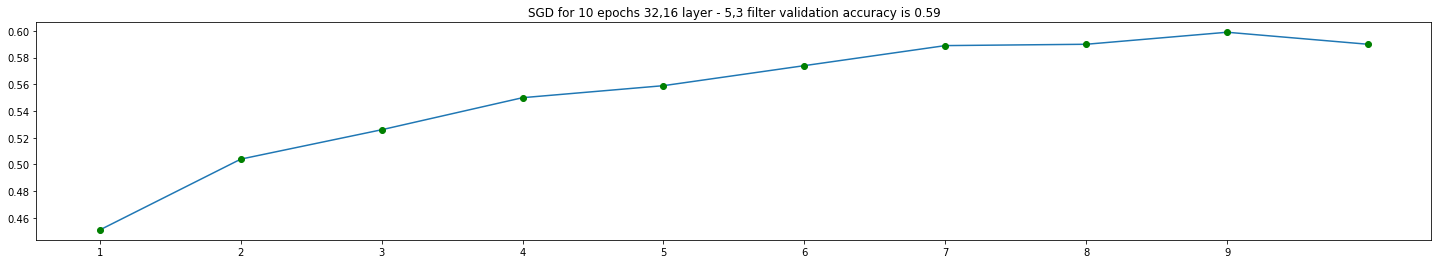

In [ ]:
params = 32, 16, 5, 3, 2, 1
learning_rate, epoch = 3e-3, 10
optimizer_name = 'SGD'
info = '32,16 layer - 5,3 filter'
plt_name = 'base'

model = model_basic(params)
optimizer = optim.SGD(model.parameters(), lr=learning_rate)
valid_acc_list = train_part34(model, optimizer, epochs=epoch)
print('max acc: ', max(valid_acc_list), ' last acc: ', valid_acc_list[-1])
plot_loss(optimizer_name, valid_acc_list, info, plt_name, epoch)


max acc:  0.653  last acc:  0.625


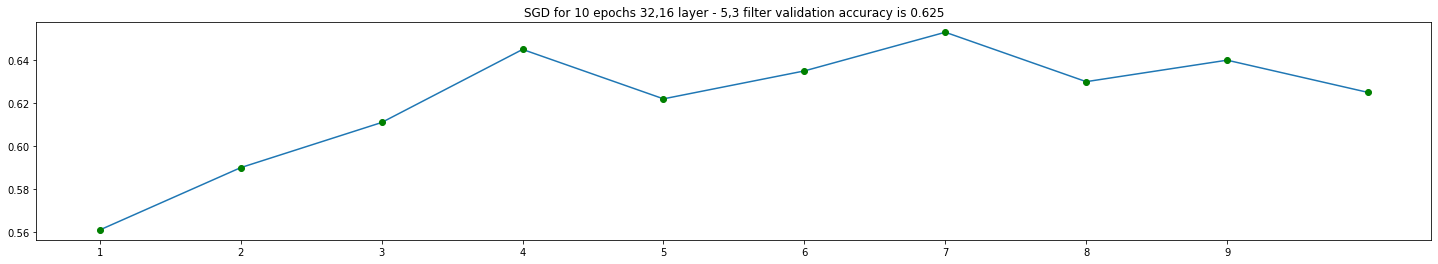

In [ ]:
params = 32, 16, 5, 3, 2, 1
learning_rate, epoch = 3e-3, 10
optimizer_name = 'SGD'
info = '32,16 layer - 5,3 filter'
plt_name = 'momentum'

model = model_basic(params)
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
valid_acc_list = train_part34(model, optimizer, epochs=epoch)
print('max acc: ', max(valid_acc_list), ' last acc: ', valid_acc_list[-1])
plot_loss(optimizer_name, valid_acc_list, info, plt_name, epoch)


max acc:  0.656  last acc:  0.628


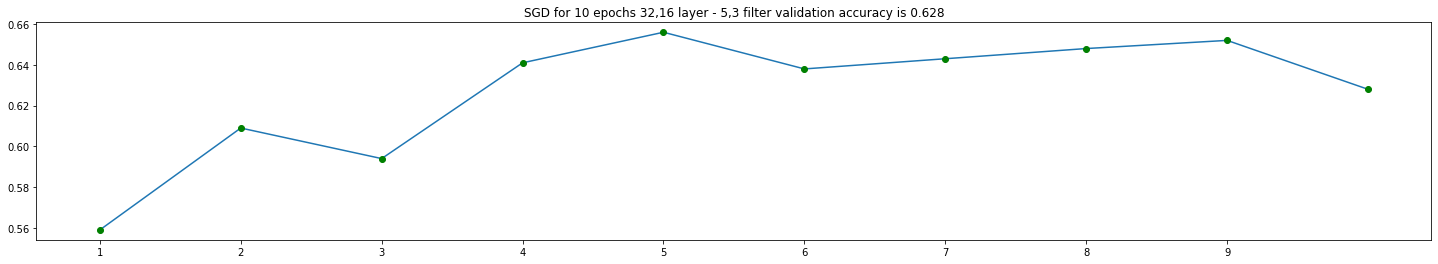

In [ ]:
params = 32, 16, 5, 3, 2, 1
learning_rate, epoch = 3e-3, 10
optimizer_name = 'SGD'
info = '32,16 layer - 5,3 filter'
plt_name = 'momentum+nesterov'

model = model_basic(params)
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, nesterov=True)
valid_acc_list = train_part34(model, optimizer, epochs=epoch)
print('max acc: ', max(valid_acc_list), ' last acc: ', valid_acc_list[-1])
plot_loss(optimizer_name, valid_acc_list, info, plt_name, epoch)


max acc:  0.656  last acc:  0.637


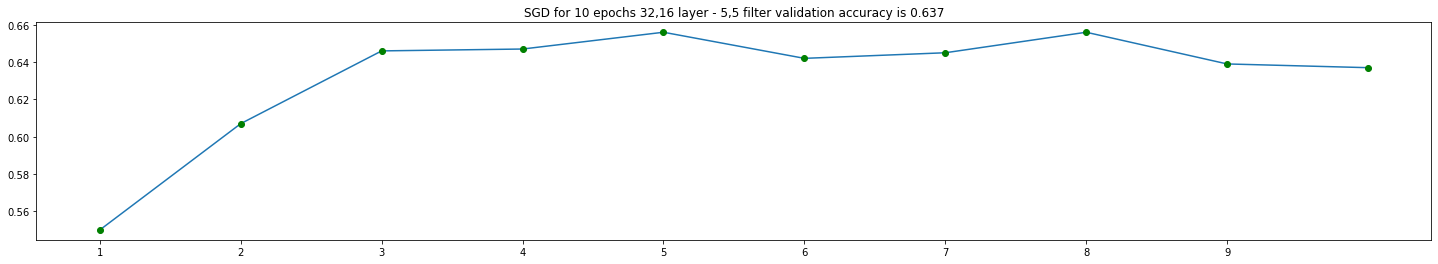

In [ ]:
params = 32, 16, 5, 5, 2, 2
learning_rate, epoch = 3e-3, 10
optimizer_name = 'SGD'
info = '32,16 layer - 5,5 filter'
plt_name = 'inc_filt_size'

model = model_basic(params)
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, nesterov=True)
valid_acc_list = train_part34(model, optimizer, epochs=epoch)
print('max acc: ', max(valid_acc_list), ' last acc: ', valid_acc_list[-1])
plot_loss(optimizer_name, valid_acc_list, info, plt_name, epoch)

max acc:  0.676  last acc:  0.638


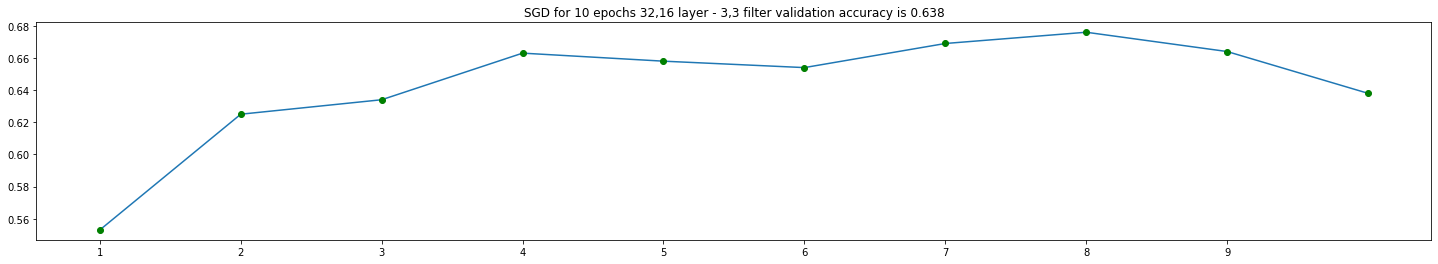

In [ ]:
params = 32, 16, 3, 3, 1, 1
learning_rate, epoch = 3e-3, 10
optimizer_name = 'SGD'
info = '32,16 layer - 3,3 filter'
plt_name = 'dec_filt_size'

model = model_basic(params)
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, nesterov=True)
valid_acc_list = train_part34(model, optimizer, epochs=epoch)
print('max acc: ', max(valid_acc_list), ' last acc: ', valid_acc_list[-1])
plot_loss(optimizer_name, valid_acc_list, info, plt_name, epoch)

max acc:  0.686  last acc:  0.655


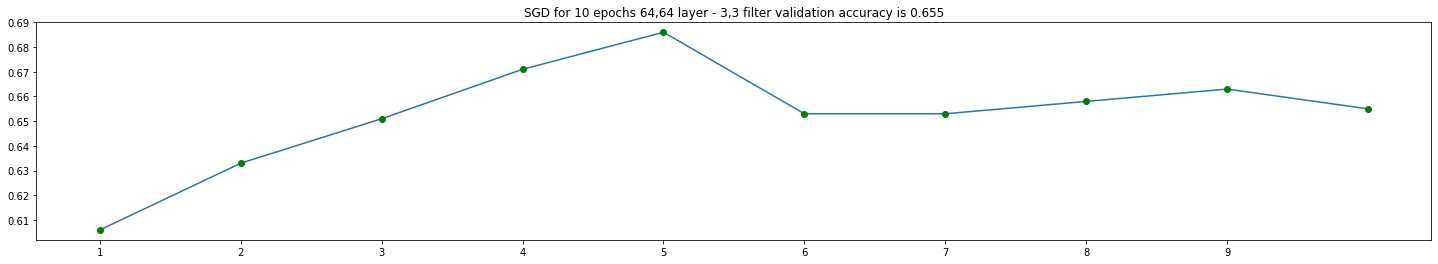

In [ ]:
params = 64, 64, 3, 3, 1, 1
learning_rate, epoch = 3e-3, 10
optimizer_name = 'SGD'
info = '64,64 layer - 3,3 filter'
plt_name = 'inc_layer-dec_filt_size'

model = model_basic(params)
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, nesterov=True)
valid_acc_list = train_part34(model, optimizer, epochs=epoch)
print('max acc: ', max(valid_acc_list), ' last acc: ', valid_acc_list[-1])
plot_loss(optimizer_name, valid_acc_list, info, plt_name, epoch)

max acc:  0.737  last acc:  0.71


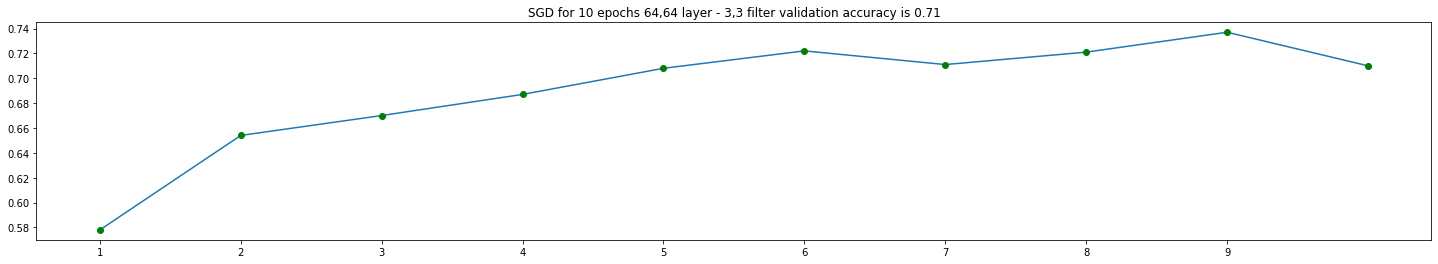

In [ ]:
params = 64, 64, 3, 3, 1, 1
learning_rate, epoch = 3e-3, 10
optimizer_name = 'SGD'
info = '64,64 layer - 3,3 filter'
plt_name = 'use_maxpool'

model = model_maxpool(params)
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, nesterov=True)
valid_acc_list = train_part34(model, optimizer, epochs=epoch)
print('max acc: ', max(valid_acc_list), ' last acc: ', valid_acc_list[-1])
plot_loss(optimizer_name, valid_acc_list, info, plt_name, epoch)

max acc:  0.735  last acc:  0.724


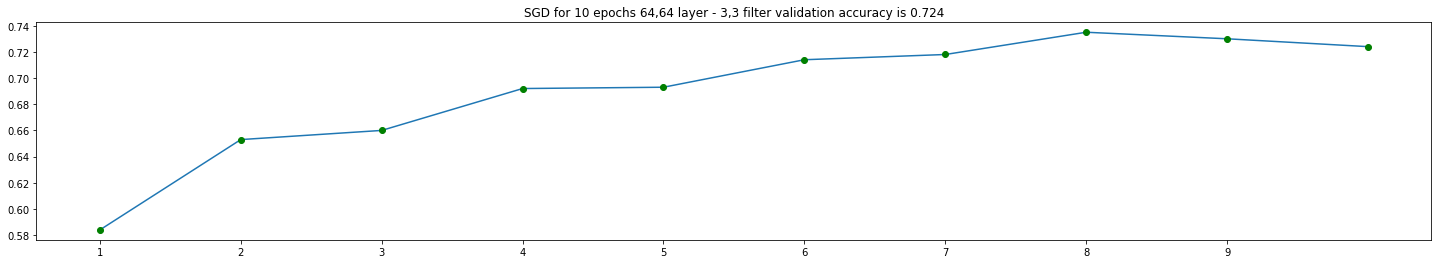

In [ ]:
params = 64, 64, 3, 3, 1, 1
learning_rate, epoch = 3e-3, 10
optimizer_name = 'SGD'
info = '64,64 layer - 3,3 filter'
plt_name = 'use_max_pool_drop'

model = model_maxpool_drop(params)
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, nesterov=True)
valid_acc_list = train_part34(model, optimizer, epochs=epoch)
print('max acc: ', max(valid_acc_list), ' last acc: ', valid_acc_list[-1])
plot_loss(optimizer_name, valid_acc_list, info, plt_name, epoch)

# Execute Model Adam

max acc:  0.745  last acc:  0.739


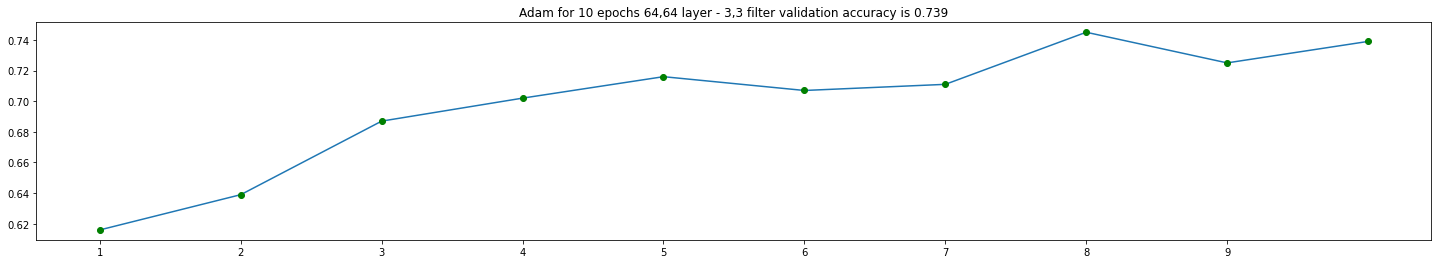

In [ ]:
params = 64, 64, 3, 3, 1, 1
learning_rate, epoch = 1e-3, 10
optimizer_name = 'Adam'
info = '64,64 layer - 3,3 filter'
plt_name = 'Use_Adam'

model = model_maxpool_drop(params)
optimizer = optim.Adam(model.parameters(), lr=learning_rate, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
#optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, nesterov=True)
valid_acc_list = train_part34(model, optimizer, epochs=epoch)
print('max acc: ', max(valid_acc_list), ' last acc: ', valid_acc_list[-1])
plot_loss(optimizer_name, valid_acc_list, info, plt_name, epoch)

max acc:  0.735  last acc:  0.72


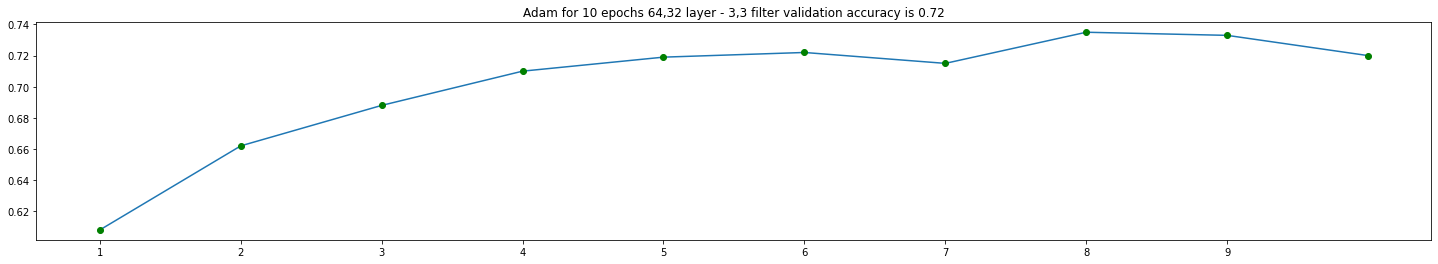

In [ ]:
# Not as good as amsgrad = False
params = 64, 64, 3, 3, 1, 1
learning_rate, epoch = 1e-3, 10
optimizer_name = 'Adam'
info = '64,64 layer - 3,3 filter'
plt_name = 'use_amsgrad'

model = model_maxpool_drop(params)
optimizer = optim.Adam(model.parameters(), lr=learning_rate, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=True)
#optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, nesterov=True)
valid_acc_list = train_part34(model, optimizer, epochs=epoch)
print('max acc: ', max(valid_acc_list), ' last acc: ', valid_acc_list[-1])
plot_loss(optimizer_name, valid_acc_list, info, plt_name, epoch)

max acc:  0.747  last acc:  0.747


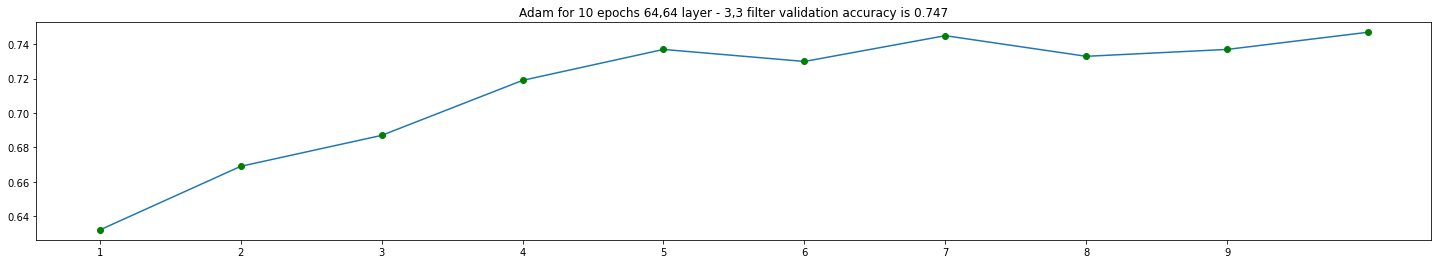

In [ ]:
#BEST MODEL
params = 64, 64, 3, 3, 1, 1
learning_rate, epoch = 1e-3, 10
optimizer_name = 'Adam'
info = '64,64 layer - 3,3 filter'
plt_name = 'use batch norm'

model = model_maxpool_drop_bn(params)
optimizer = optim.Adam(model.parameters(), lr=learning_rate, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
#optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, nesterov=True)
valid_acc_list = train_part34(model, optimizer, epochs=epoch)
print('max acc: ', max(valid_acc_list), ' last acc: ', valid_acc_list[-1])
plot_loss(optimizer_name, valid_acc_list, info, plt_name, epoch)

# Add Batch Norm Layer

max acc:  0.73  last acc:  0.73


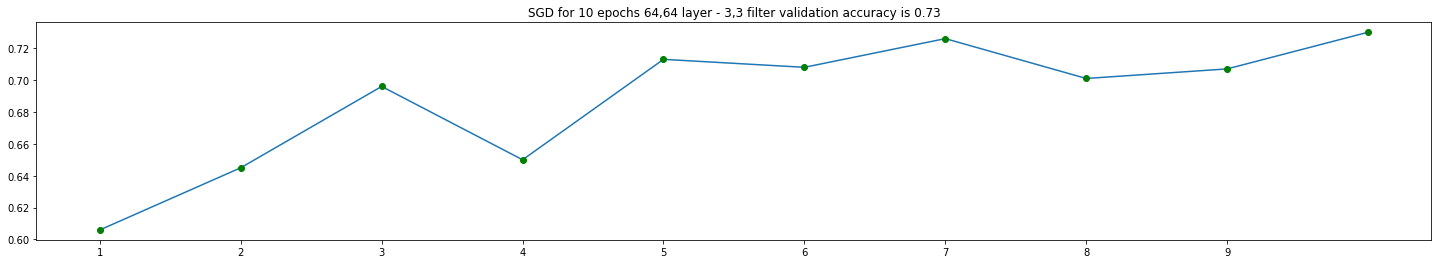

In [ ]:
params = 64, 64, 3, 3, 1, 1
learning_rate, epoch = 1e-3, 10
optimizer_name = 'SGD'
info = '64,64 layer - 3,3 filter'
plt_name = 'use batch norm with sgd momentum'

model = model_maxpool_drop_bn(params)
#optimizer = optim.Adam(model.parameters(), lr=learning_rate, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, nesterov=True)
valid_acc_list = train_part34(model, optimizer, epochs=epoch)
print('max acc: ', max(valid_acc_list), ' last acc: ', valid_acc_list[-1])
plot_loss(optimizer_name, valid_acc_list, info, plt_name, epoch)

max acc:  0.733  last acc:  0.728


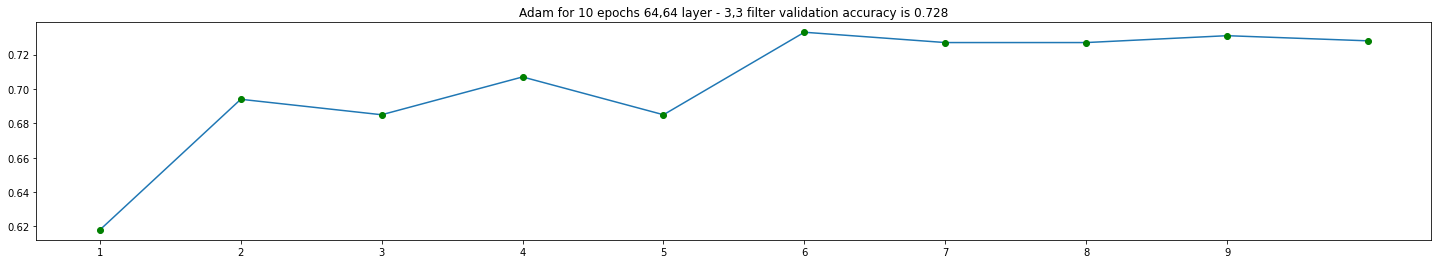

In [ ]:
params = 64, 64, 3, 3, 1, 1
learning_rate, epoch = 1e-3, 10
optimizer_name = 'Adam'
info = '64,64 layer - 3,3 filter'
plt_name = 'dont use dropout'

model = model_maxpool_bn(params)
optimizer = optim.Adam(model.parameters(), lr=learning_rate, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
#optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, nesterov=True)
valid_acc_list = train_part34(model, optimizer, epochs=epoch)
print('max acc: ', max(valid_acc_list), ' last acc: ', valid_acc_list[-1])
plot_loss(optimizer_name, valid_acc_list, info, plt_name, epoch)

max acc:  0.757  last acc:  0.743


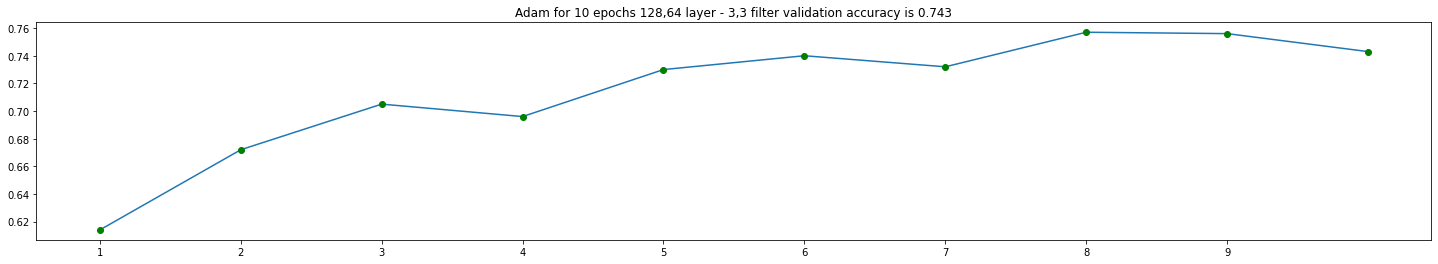

In [ ]:

params = 128, 64, 3, 3, 1, 1
learning_rate, epoch = 1e-3, 10
optimizer_name = 'Adam'
info = '128,64 layer - 3,3 filter'
plt_name = 'Increase layer'

model = model_maxpool_drop_bn(params)
optimizer = optim.Adam(model.parameters(), lr=learning_rate, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
#optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, nesterov=True)
valid_acc_list = train_part34(model, optimizer, epochs=epoch)
print('max acc: ', max(valid_acc_list), ' last acc: ', valid_acc_list[-1])
plot_loss(optimizer_name, valid_acc_list, info, plt_name, epoch)

Got 128 / 1000 correct (12.80)
Got 445 / 1000 correct (44.50)
Got 520 / 1000 correct (52.00)
Got 554 / 1000 correct (55.40)
Got 595 / 1000 correct (59.50)
Got 629 / 1000 correct (62.90)
Got 626 / 1000 correct (62.60)
Got 627 / 1000 correct (62.70)
Got 628 / 1000 correct (62.80)
Got 628 / 1000 correct (62.80)
Got 688 / 1000 correct (68.80)
Got 646 / 1000 correct (64.60)
Got 617 / 1000 correct (61.70)
Got 649 / 1000 correct (64.90)
Got 680 / 1000 correct (68.00)
Got 695 / 1000 correct (69.50)
Got 633 / 1000 correct (63.30)
Got 662 / 1000 correct (66.20)
Got 697 / 1000 correct (69.70)
Got 678 / 1000 correct (67.80)
Got 716 / 1000 correct (71.60)
Got 710 / 1000 correct (71.00)
Got 692 / 1000 correct (69.20)
Got 725 / 1000 correct (72.50)
Got 707 / 1000 correct (70.70)
Got 727 / 1000 correct (72.70)
Got 695 / 1000 correct (69.50)
Got 699 / 1000 correct (69.90)
Got 702 / 1000 correct (70.20)
Got 742 / 1000 correct (74.20)
Got 691 / 1000 correct (69.10)
Got 721 / 1000 correct (72.10)
Got 718 

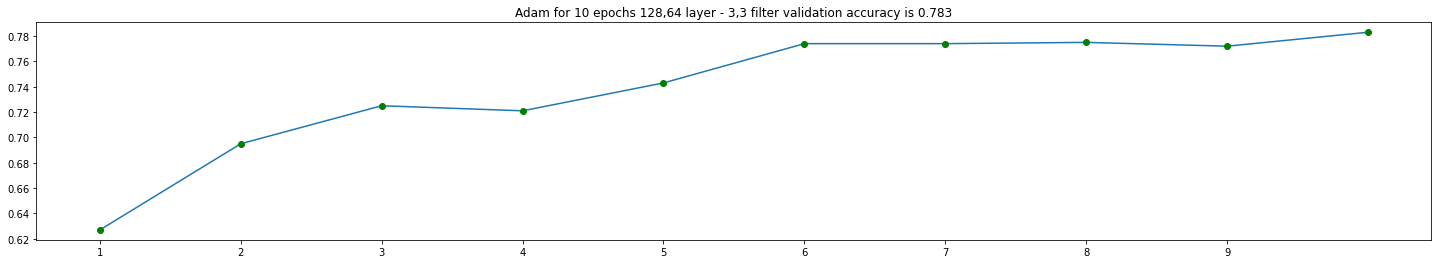

In [ ]:
params = 128, 64, 32, 3, 3, 3, 1, 1, 1
learning_rate, epoch = 1e-3, 10
optimizer_name = 'Adam'
info = '128,64 layer - 3,3 filter'
plt_name = 'Increase hidden layer'

model = model_maxpool_drop_bn_three(params)
optimizer = optim.Adam(model.parameters(), lr=learning_rate, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
#optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, nesterov=True)
valid_acc_list = train_part34(model, optimizer, epochs=epoch)
print('max acc: ', max(valid_acc_list), ' last acc: ', valid_acc_list[-1])
plot_loss(optimizer_name, valid_acc_list, info, plt_name, epoch)

In [ ]:
check_accuracy_part34(loader_test, model)

Got 7759 / 10000 correct (77.59)


0.7759

# Different Initializations

In [47]:
def init_weights_zeros(m):
    if type(m) == nn.Linear:
        torch.nn.init.zeros_(m.weight)
        torch.nn.init.constant_(m.bias, 0.01)


def init_weights_normal(m):
    if type(m) == nn.Linear:
        torch.nn.init.normal_(m.weight)
        torch.nn.init.constant_(m.bias, 0.01)


def init_weights_xavier(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform_(m.weight)
        # m.bias.data.fill_(0.01)
        torch.nn.init.constant_(m.bias, 0.01)

def init_weights_xavier_all(m):
    if isinstance(m, nn.Conv2d):
        torch.nn.init.xavier_uniform_(m.weight)
        torch.nn.init.constant_(m.bias, 0.01)


def init_xaiver(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform_(m.weight)
        torch.nn.init.constant_(m.bias, 0.01)
    if isinstance(m, nn.Conv2d):
        torch.nn.init.xavier_uniform_(m.weight)
        torch.nn.init.constant_(m.bias, 0.01)

def init_weights_kaiming(m):
    if type(m) == nn.Linear:
      torch.nn.init.kaiming_uniform_(m.weight)
      torch.nn.init.constant_(m.bias, 0.01)


def init_weights_kaiming_all(m):
    if isinstance(m, nn.Conv2d):
        torch.nn.init.kaiming_uniform_(m.weight)
        torch.nn.init.constant_(m.bias, 0.01)


def init_kaiming(m):
    if type(m) == nn.Linear:
        torch.nn.init.kaiming_uniform_(m.weight)
        torch.nn.init.constant_(m.bias, 0.01)
    if isinstance(m, nn.Conv2d):
        torch.nn.init.kaiming_uniform_(m.weight)
        torch.nn.init.constant_(m.bias, 0.01)


max acc:  0.728  last acc:  0.728


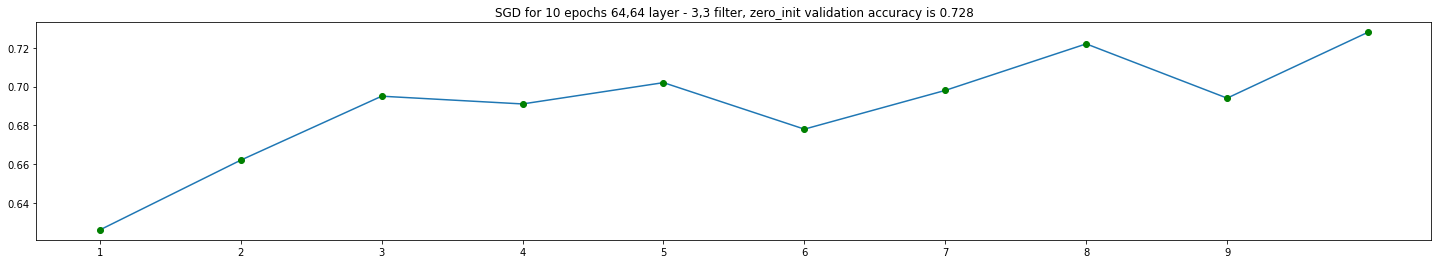

In [24]:
params = 64, 64, 3, 3, 1, 1
learning_rate, epoch = 1e-3, 10
optimizer_name = 'SGD'
info = '64,64 layer - 3,3 filter, zero_init'
plt_name = 'zero_init'

model = model_maxpool_drop_bn(params)
model.apply(init_weights_zeros)
#optimizer = optim.Adam(model.parameters(), lr=learning_rate, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, nesterov=True)
valid_acc_list = train_part34(model, optimizer, epochs=epoch)
print('max acc: ', max(valid_acc_list), ' last acc: ', valid_acc_list[-1])
plot_loss(optimizer_name, valid_acc_list, info, plt_name, epoch)

max acc:  0.379  last acc:  0.378


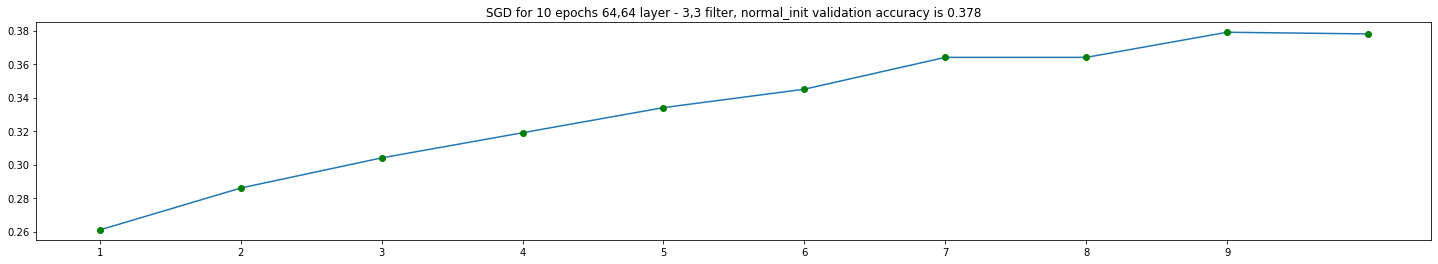

In [25]:
params = 64, 64, 3, 3, 1, 1
learning_rate, epoch = 1e-3, 10
optimizer_name = 'SGD'
info = '64,64 layer - 3,3 filter, normal_init'
plt_name = 'normal_init'

model = model_maxpool_drop_bn(params)
model.apply(init_weights_normal)
#optimizer = optim.Adam(model.parameters(), lr=learning_rate, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, nesterov=True)
valid_acc_list = train_part34(model, optimizer, epochs=epoch)
print('max acc: ', max(valid_acc_list), ' last acc: ', valid_acc_list[-1])
plot_loss(optimizer_name, valid_acc_list, info, plt_name, epoch)

max acc:  0.723  last acc:  0.717


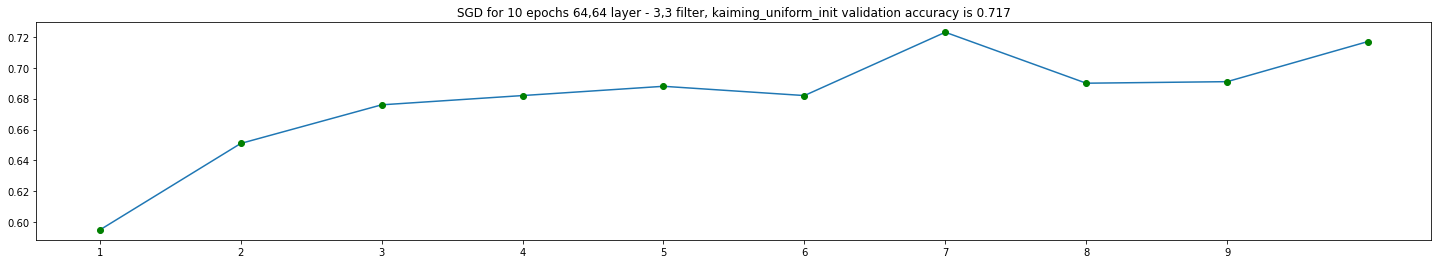

In [33]:
params = 64, 64, 3, 3, 1, 1
learning_rate, epoch = 1e-3, 10
optimizer_name = 'SGD'
info = '64,64 layer - 3,3 filter, kaiming_uniform_init'
plt_name = 'kaiming_uniform_init'

model = model_maxpool_drop_bn(params)
model.apply(init_weights_kaiming)
#optimizer = optim.Adam(model.parameters(), lr=learning_rate, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, nesterov=True)
valid_acc_list = train_part34(model, optimizer, epochs=epoch)
print('max acc: ', max(valid_acc_list), ' last acc: ', valid_acc_list[-1])
plot_loss(optimizer_name, valid_acc_list, info, plt_name, epoch)

max acc:  0.72  last acc:  0.72


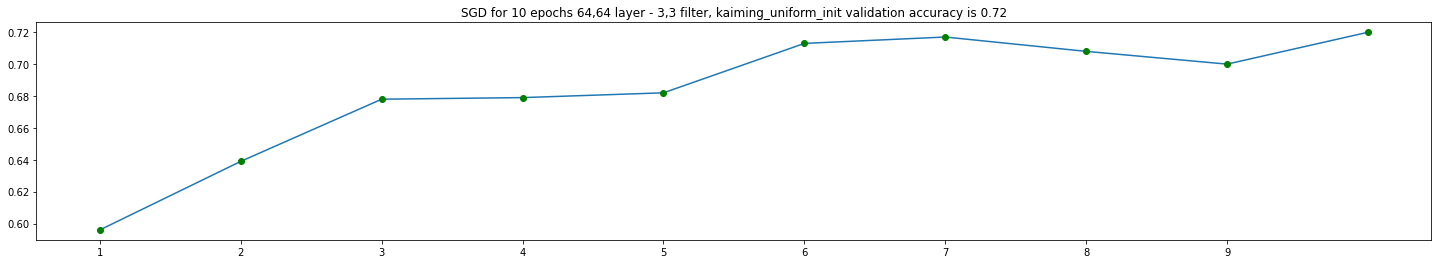

In [29]:
params = 64, 64, 3, 3, 1, 1
learning_rate, epoch = 1e-3, 10
optimizer_name = 'SGD'
info = '64,64 layer - 3,3 filter, xavier_uniform_init'
plt_name = 'xavier_uniform_init'

model = model_maxpool_drop_bn(params)
model.apply(init_weights_xavier)
#optimizer = optim.Adam(model.parameters(), lr=learning_rate, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, nesterov=True)
valid_acc_list = train_part34(model, optimizer, epochs=epoch)
print('max acc: ', max(valid_acc_list), ' last acc: ', valid_acc_list[-1])
plot_loss(optimizer_name, valid_acc_list, info, plt_name, epoch)

max acc:  0.739  last acc:  0.739


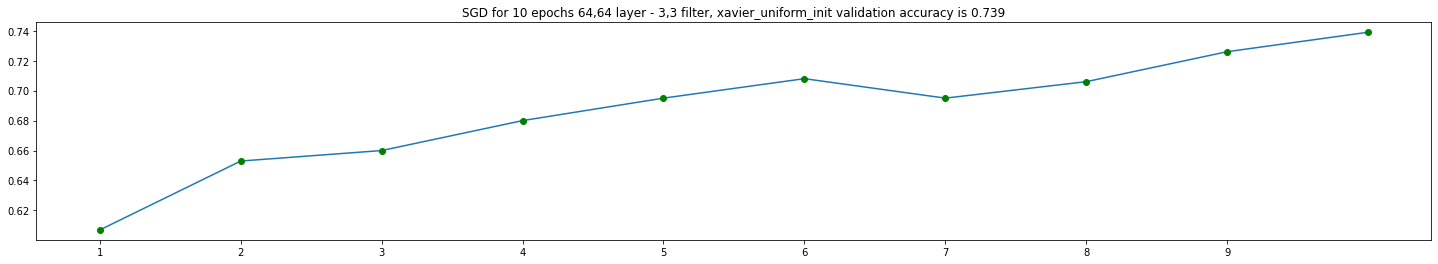

In [38]:
params = 64, 64, 3, 3, 1, 1
learning_rate, epoch = 1e-3, 10
optimizer_name = 'SGD'
info = '64,64 layer - 3,3 filter, xavier_uniform_init'
plt_name = 'xavier_uniform_init'

model = model_maxpool_drop_bn(params)
model.apply(init_weights_xavier_all)
#optimizer = optim.Adam(model.parameters(), lr=learning_rate, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, nesterov=True)
valid_acc_list = train_part34(model, optimizer, epochs=epoch)
print('max acc: ', max(valid_acc_list), ' last acc: ', valid_acc_list[-1])
plot_loss(optimizer_name, valid_acc_list, info, plt_name, epoch)

max acc:  0.757  last acc:  0.735


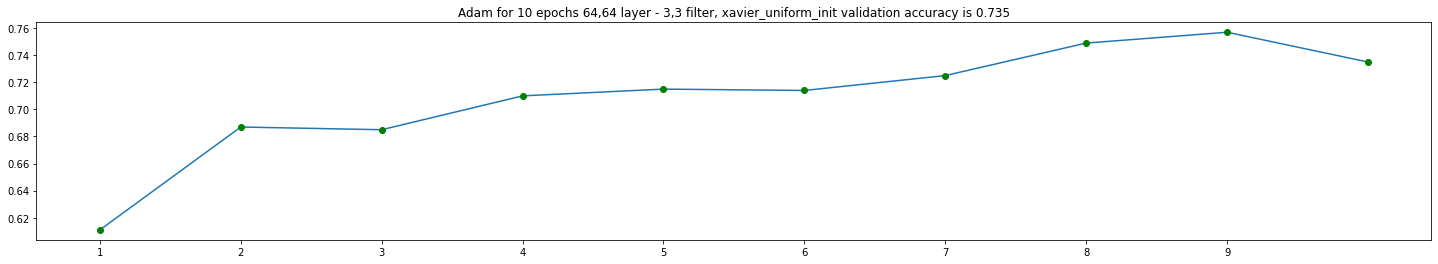

In [39]:
params = 64, 64, 3, 3, 1, 1
learning_rate, epoch = 1e-3, 10
optimizer_name = 'Adam'
info = '64,64 layer - 3,3 filter, xavier_uniform_init_all'
plt_name = 'xavier_uniform_init_all'

model = model_maxpool_drop_bn(params)
model.apply(init_weights_xavier_all)
optimizer = optim.Adam(model.parameters(), lr=learning_rate, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
#optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, nesterov=True)
valid_acc_list = train_part34(model, optimizer, epochs=epoch)
print('max acc: ', max(valid_acc_list), ' last acc: ', valid_acc_list[-1])
plot_loss(optimizer_name, valid_acc_list, info, plt_name, epoch)

max acc:  0.746  last acc:  0.745


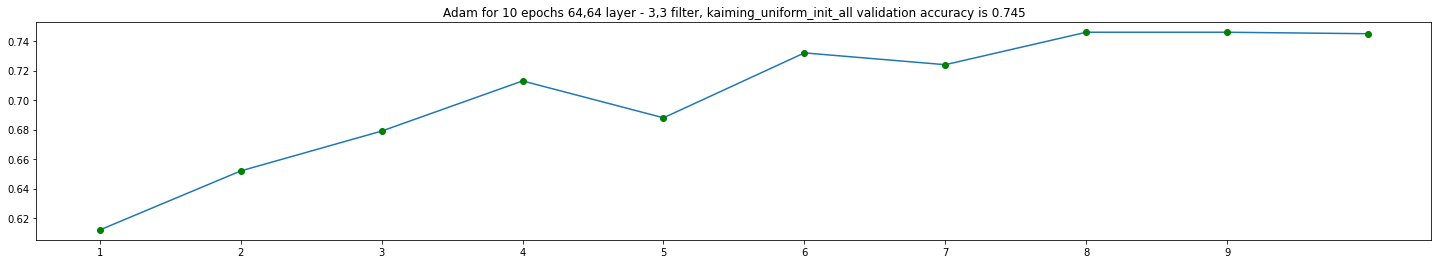

In [42]:
params = 64, 64, 3, 3, 1, 1
learning_rate, epoch = 1e-3, 10
optimizer_name = 'Adam'
info = '64,64 layer - 3,3 filter, kaiming_uniform_init_all'
plt_name = 'kaiming_uniform_init_all'

model = model_maxpool_drop_bn(params)
model.apply(init_weights_kaiming_all)
optimizer = optim.Adam(model.parameters(), lr=learning_rate, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
#optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, nesterov=True)
valid_acc_list = train_part34(model, optimizer, epochs=epoch)
print('max acc: ', max(valid_acc_list), ' last acc: ', valid_acc_list[-1])
plot_loss(optimizer_name, valid_acc_list, info, plt_name, epoch)

max acc:  0.775  last acc:  0.757


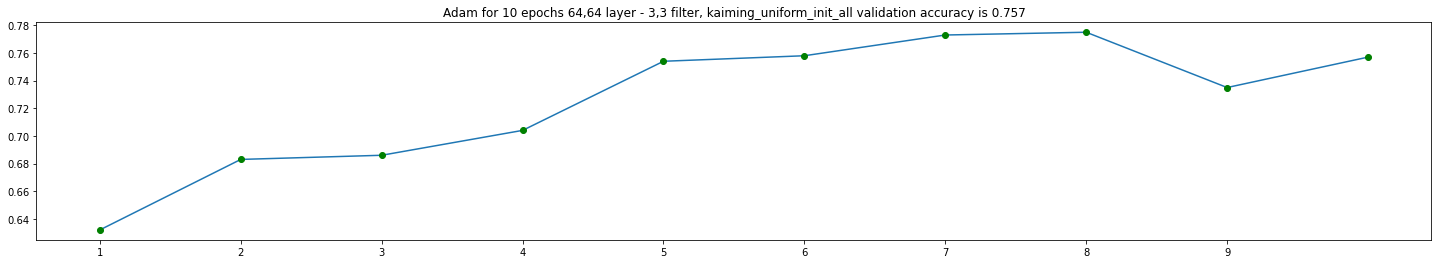

In [43]:
params = 128, 64, 32, 3, 3, 3, 1, 1, 1
learning_rate, epoch = 1e-3, 10
optimizer_name = 'Adam'
info = '128, 64, 32 layer - 3,3 filter, kaiming_uniform_init_all'
plt_name = 'kaiming_uniform_init_all'

model = model_maxpool_drop_bn_three(params)
model.apply(init_weights_kaiming_all)
optimizer = optim.Adam(model.parameters(), lr=learning_rate, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
#optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, nesterov=True)
valid_acc_list = train_part34(model, optimizer, epochs=epoch)
print('max acc: ', max(valid_acc_list), ' last acc: ', valid_acc_list[-1])
plot_loss(optimizer_name, valid_acc_list, info, plt_name, epoch)

max acc:  0.764  last acc:  0.762


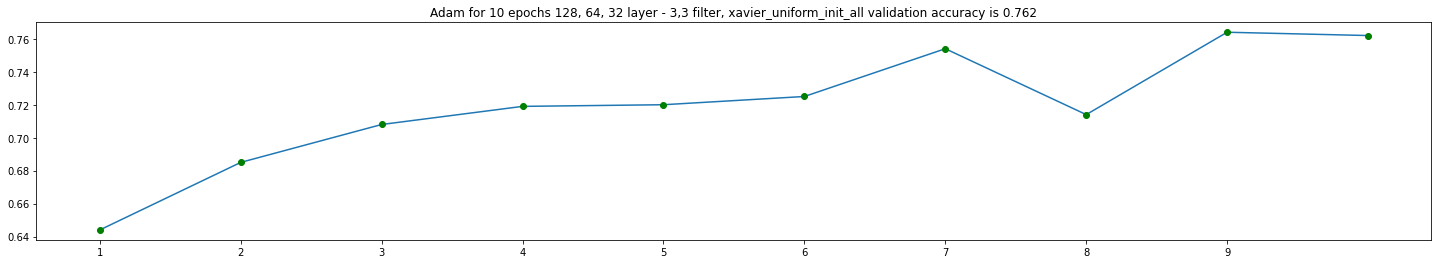

In [44]:
params = 128, 64, 32, 3, 3, 3, 1, 1, 1
learning_rate, epoch = 1e-3, 10
optimizer_name = 'Adam'
info = '128, 64, 32 layer - 3,3 filter, xavier_uniform_init_all'
plt_name = 'xavier_uniform_init_all'

model = model_maxpool_drop_bn_three(params)
model.apply(init_weights_xavier_all)
optimizer = optim.Adam(model.parameters(), lr=learning_rate, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
#optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, nesterov=True)
valid_acc_list = train_part34(model, optimizer, epochs=epoch)
print('max acc: ', max(valid_acc_list), ' last acc: ', valid_acc_list[-1])
plot_loss(optimizer_name, valid_acc_list, info, plt_name, epoch)

max acc:  0.778  last acc:  0.778


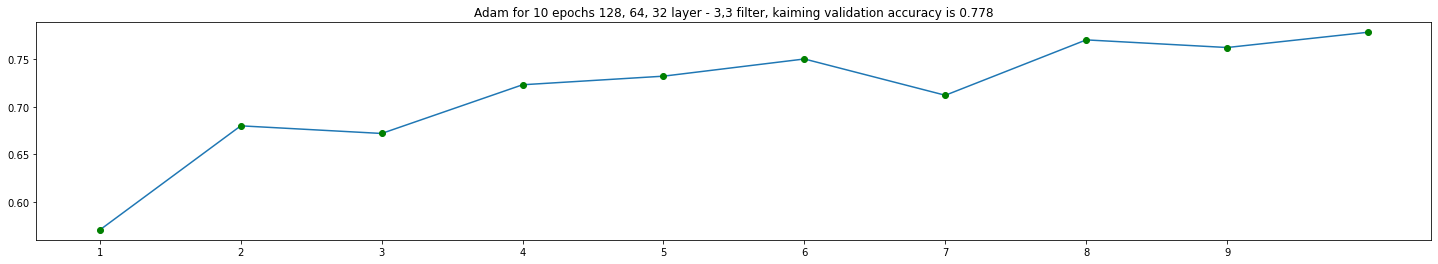

In [46]:
params = 128, 64, 32, 3, 3, 3, 1, 1, 1
learning_rate, epoch = 1e-3, 10
optimizer_name = 'Adam'
info = '128, 64, 32 layer - 3,3 filter, kaiming'
plt_name = 'xavier_uniform_init_all'

model = model_maxpool_drop_bn_three(params)
model.apply(init_kaiming)
optimizer = optim.Adam(model.parameters(), lr=learning_rate, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
#optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, nesterov=True)
valid_acc_list = train_part34(model, optimizer, epochs=epoch)
print('max acc: ', max(valid_acc_list), ' last acc: ', valid_acc_list[-1])
plot_loss(optimizer_name, valid_acc_list, info, plt_name, epoch)

max acc:  0.783  last acc:  0.783


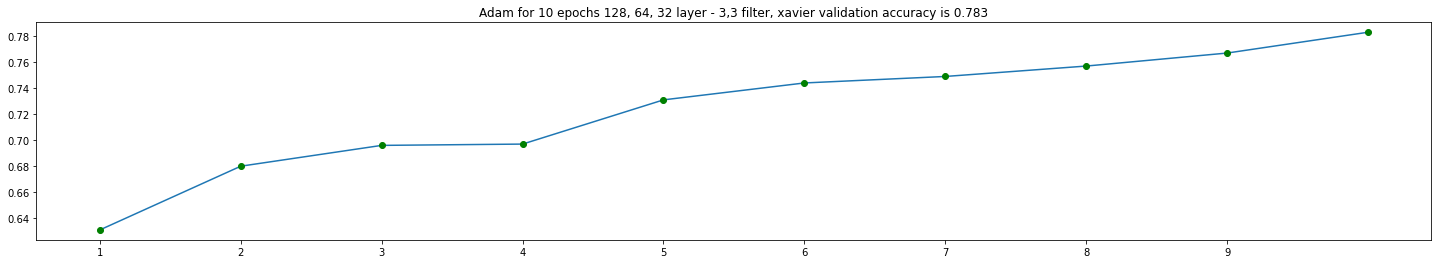

In [48]:
params = 128, 64, 32, 3, 3, 3, 1, 1, 1
learning_rate, epoch = 1e-3, 10
optimizer_name = 'Adam'
info = '128, 64, 32 layer - 3,3 filter, xavier'
plt_name = 'xavier'

model = model_maxpool_drop_bn_three(params)
model.apply(init_xaiver)
optimizer = optim.Adam(model.parameters(), lr=learning_rate, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
#optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, nesterov=True)
valid_acc_list = train_part34(model, optimizer, epochs=epoch)
print('max acc: ', max(valid_acc_list), ' last acc: ', valid_acc_list[-1])
plot_loss(optimizer_name, valid_acc_list, info, plt_name, epoch)